In [1]:
import torch
import torch.nn as nn
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from sklearn.model_selection import train_test_split

In [3]:
NUM_FEATURES = 4
NUM_CLASSES = 4
RANDOM_SEED = 42

In [30]:
X , y = make_blobs(n_samples=1000, n_features=NUM_FEATURES,cluster_std=2.3 , centers=NUM_CLASSES, random_state=RANDOM_SEED)

In [31]:
X= torch.from_numpy(X).float()
y= torch.from_numpy(y).float()

In [32]:
import pandas as pd

data = torch.cat((X, y.unsqueeze(1)), dim=1)
df = pd.DataFrame(
    data.numpy(), columns=[f"Feature_{i}" for i in range(NUM_FEATURES)] + ["Class"]
)
df

,Feature_0,Feature_1,Feature_2,Feature_3,Class
0,-9.978018,-9.114821,-6.077376,5.812666,1.0
1,-4.294168,-4.700799,-10.615947,8.259743,1.0
2,-3.549502,3.439364,0.996902,3.722123,0.0
3,-1.911467,10.812479,1.794892,-1.063881,0.0
4,-4.588717,-8.620738,-12.108492,10.776590,1.0
...,...,...,...,...,...
995,4.854395,-2.692895,-9.116115,-4.276405,3.0
996,2.187985,3.673371,-11.777722,9.576403,2.0
997,-3.064982,7.688349,-12.863412,8.784897,2.0
998,7.389642,-5.778729,-8.233434,-4.438366,3.0


In [33]:
X, y

(tensor([[ -9.9780,  -9.1148,  -6.0774,   5.8127],
         [ -4.2942,  -4.7008, -10.6159,   8.2597],
         [ -3.5495,   3.4394,   0.9969,   3.7221],
         ...,
         [ -3.0650,   7.6883, -12.8634,   8.7849],
         [  7.3896,  -5.7787,  -8.2334,  -4.4384],
         [ -3.7506,   7.2242,   5.0903,  -0.2771]]),
 tensor([1., 1., 0., 0., 1., 0., 3., 1., 2., 2., 0., 0., 0., 3., 2., 3., 1., 0.,
         3., 0., 0., 1., 0., 0., 1., 2., 1., 2., 3., 2., 2., 3., 2., 3., 3., 2.,
         2., 0., 2., 2., 0., 3., 2., 3., 1., 1., 1., 3., 1., 2., 3., 2., 2., 2.,
         1., 3., 1., 1., 0., 2., 2., 2., 1., 0., 2., 2., 2., 1., 3., 1., 0., 0.,
         3., 2., 0., 0., 2., 3., 1., 2., 3., 1., 2., 0., 0., 0., 2., 1., 1., 1.,
         1., 2., 3., 3., 0., 1., 0., 3., 1., 0., 3., 3., 1., 2., 0., 3., 0., 3.,
         1., 3., 1., 2., 3., 3., 1., 2., 1., 2., 2., 2., 2., 0., 1., 0., 1., 0.,
         2., 2., 0., 0., 3., 1., 3., 2., 1., 2., 1., 0., 2., 3., 3., 2., 1., 0.,
         2., 3., 1., 1., 0., 3

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)  

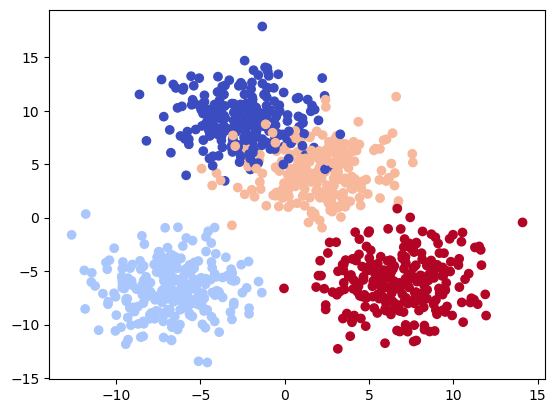

In [36]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [40]:
class MakeBlob(nn.Module):
    def __init__(self, input_features, output_features, hidden_units) -> None:
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)

In [41]:
model0 = MakeBlob(4, 4, 64).to(device)

In [42]:
model0

MakeBlob(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [43]:
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model0.parameters(), lr=0.001)

In [45]:
NUM_EPOCHS = 1000

TRAIN_LOSS = []
TEST_LOSS = []
TRAIN_ACC = []
TEST_ACC = []


In [46]:
def accuracy(y_pred, y_true):
    # Ensure y_pred and y_true are tensors
    y_pred = y_pred.to(torch.int)
    y_true = y_true.to(torch.int)

    # Calculate the number of correct predictions
    correct = torch.eq(y_pred, y_true).sum().item()

    # Calculate accuracy as a percentage
    acc = (correct / len(y_true)) * 100
    return acc

In [48]:
X_test = X_test.to(device)
y_test = y_test.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)


In [51]:
for epoch in range(NUM_EPOCHS):
    
    model0.train()
    
    y_logits = model0(X_train).squeeze()
    
    loss = loss_function(y_logits, y_train.long())
    
    y_pred  = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    acc  = accuracy(y_pred, y_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model0.eval()
    
    with torch.inference_mode():
        y_logits = model0(X_test).squeeze()
        
        test_loss = loss_function(y_logits, y_test.long())
        
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        
        test_acc = accuracy(y_pred, y_test)
        
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Train Loss: {loss.item()} Test Loss: {test_loss.item()} Train Acc: {acc} Test Acc: {test_acc}")
        
        TRAIN_ACC.append(acc)
        TEST_ACC.append(test_acc)
        TRAIN_LOSS.append(loss.item())
        TEST_LOSS.append(test_loss.item())

Epoch 0 Train Loss: 1.3043105602264404 Test Loss: 1.2648597955703735 Train Acc: 32.125 Test Acc: 40.0
Epoch 100 Train Loss: 0.4794236719608307 Test Loss: 0.47442588210105896 Train Acc: 96.625 Test Acc: 96.0
Epoch 200 Train Loss: 0.26338016986846924 Test Loss: 0.2624856233596802 Train Acc: 99.875 Test Acc: 100.0
Epoch 300 Train Loss: 0.1686328649520874 Test Loss: 0.1692747324705124 Train Acc: 99.875 Test Acc: 100.0
Epoch 400 Train Loss: 0.11959369480609894 Test Loss: 0.12063156068325043 Train Acc: 99.875 Test Acc: 100.0
Epoch 500 Train Loss: 0.09110940247774124 Test Loss: 0.09212224930524826 Train Acc: 99.875 Test Acc: 100.0
Epoch 600 Train Loss: 0.07294425368309021 Test Loss: 0.07383608818054199 Train Acc: 99.875 Test Acc: 100.0
Epoch 700 Train Loss: 0.060532983392477036 Test Loss: 0.06128785014152527 Train Acc: 99.875 Test Acc: 100.0
Epoch 800 Train Loss: 0.051585033535957336 Test Loss: 0.05221223831176758 Train Acc: 99.875 Test Acc: 100.0
Epoch 900 Train Loss: 0.04486890137195587 Tes

In [52]:
from helper import plot_decision_boundary

In [54]:
X.shape

torch.Size([1000, 4])

In [55]:
y.shape

torch.Size([1000])

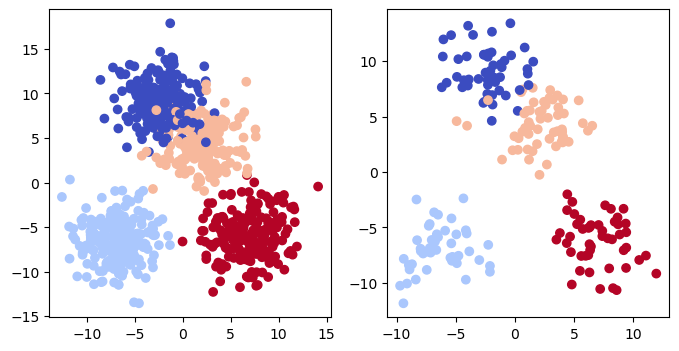

In [83]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0].cpu().numpy(), X_train[:, 1].cpu().numpy(), c=y_train.cpu().numpy(), cmap=plt.cm.coolwarm)
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), c=y_test.cpu().numpy(), cmap=plt.cm.coolwarm)

tensor([0., 2., 0., 1., 1., 3., 2., 0., 1., 1., 0., 2., 1., 0., 1., 0., 0., 1.,
        0., 0., 2., 2., 1., 3., 0., 1., 3., 1., 2., 2., 3., 3., 0., 2., 2., 3.,
        2., 2., 1., 2., 0., 0., 1., 0., 0., 1., 0., 2., 0., 2., 3., 3., 3., 0.,
        0., 2., 2., 0., 0., 0., 3., 1., 2., 3., 1., 3., 1., 0., 0., 0., 3., 0.,
        2., 2., 1., 1., 3., 2., 2., 1., 1., 2., 0., 1., 3., 0., 3., 1., 1., 3.,
        1., 1., 3., 3., 3., 1., 3., 1., 0., 2., 2., 0., 1., 2., 3., 3., 2., 1.,
        2., 1., 2., 1., 1., 2., 2., 1., 2., 1., 0., 3., 3., 0., 3., 0., 0., 3.,
        2., 2., 2., 2., 2., 3., 2., 3., 3., 3., 2., 2., 2., 3., 1., 0., 2., 0.,
        3., 3., 3., 2., 2., 3., 3., 3., 2., 2., 0., 0., 1., 0., 2., 2., 0., 2.,
        1., 2., 2., 0., 0., 0., 2., 0., 3., 3., 1., 3., 2., 3., 2., 3., 3., 1.,
        2., 0., 1., 1., 2., 0., 0., 1., 3., 3., 3., 0., 1., 2., 3., 0., 1., 2.,
        0., 1.], device='cuda:0')

In [61]:
X_test = X_test.to(device)
X_train = X_train.to(device)
y_test = y_test.to(device)
y_train = y_train.to(device)


In [68]:
model0 = model0.to(device)

In [77]:
with torch.inference_mode():
    y_logits = model0(X_test).squeeze()
    y_pred  = torch.softmax(y_logits, dim=1).argmax(dim=1)
    print(y_pred == y_test)
    print(all(y_pred == y_test))

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [84]:
from helper import plot_decision_boundary

In [90]:
%pip install torchmetrics

   ---------------------------------------- 0.0/869.2 kB ? eta -:--:--
    -------------------------------------- 20.5/869.2 kB 330.3 kB/s eta 0:00:03
   - ------------------------------------- 30.7/869.2 kB 325.1 kB/s eta 0:00:03
   --- ----------------------------------- 71.7/869.2 kB 563.7 kB/s eta 0:00:02
   ---- --------------------------------- 102.4/869.2 kB 590.8 kB/s eta 0:00:02
   ------ ------------------------------- 153.6/869.2 kB 706.2 kB/s eta 0:00:02
   -------- ----------------------------- 184.3/869.2 kB 743.9 kB/s eta 0:00:01
   ----------- -------------------------- 256.0/869.2 kB 827.5 kB/s eta 0:00:01
   ------------ ------------------------- 286.7/869.2 kB 803.7 kB/s eta 0:00:01
   -------------- ----------------------- 337.9/869.2 kB 838.1 kB/s eta 0:00:01
   ----------------- -------------------- 389.1/869.2 kB 865.0 kB/s eta 0:00:01
   ------------------ ------------------- 419.8/869.2 kB 873.3 kB/s eta 0:00:01
   -------------------- ----------------- 471.0/8

In [91]:
from torchmetrics import Accuracy   

In [96]:
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)


In [100]:
ans= torchmetrics_accuracy(y_pred, y_test)
ans.item()

1.0